In [1]:
##################################################################################################
# Licensed under the Apache License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may obtain
# a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
# License for the specific language governing permissions and limitations
# under the License.
#
##################################################################################################
# This project is illuminated by                                                                 #
# https://developer.ibm.com/cn/patterns/build-a-recommender-with-apache-spark-and-elasticsearch/ #
##################################################################################################

In [90]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, HTML, display
from elasticsearch import Elasticsearch

from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, udf, lit, current_timestamp, unix_timestamp, array_contains

from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator


# Spark Project 3


# Movie Recommender System with Apache Spark & Elasticsearch

## 0. Abstract

 
In this project, we build a recommender engine using Apache Spark and Elasticsearch. The recommendation model is trained in Spark using matrix factorization method and alternating least squares technique. Elasticsearch (and its vector scoring plugin) is used to persist the trained model, query, score, rank, and display results, such as the movies that certain users may find interesting. We also use [The Movie Database (TMdb) API](https://www.themoviedb.org/documentation/api) to dislay recommended movie posters to the user.


## 1. Data Wrangling

We use the small version of MovieLens dataset on movie ratings with about 100,000 ratings, 9,000 movies and 600 users. There there `.csv` files in the dateset zip folder, `ratings.csv`, `links.csv`, `movies.csv`.

There are 100,836 rows and 4 columns in `ratings.csv`. Read `ratings.csv` into Spark DataFrame, 
```
Sample of ratings:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows
```
There are 9742 rows and 3 columns in `movies.csv`. Read `movies.csv` into Spark DataFrame, 
```
Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows
```

Notice that the `titile` column contains the relase year and the `generes` is dilimited string. We can use regular expression and Spark udf to extract the relase year to a single column, and make the data typle of the column `genres` into a list of string, like

```
Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows

```

To recommend movies to a new user, we can let him / her choose speific interesting genres first, and then give him / her movies recommendation in those genres. 

The `link.csv` contains the map of movie ID in `movies.csv` and TMDb ID.

### Spark SQL and OLAP

#### Q1: The number of Users

In [59]:
ratings.select('userID').distinct().count()

610

#### Q2: The number of Movies

In [60]:
movies.select('movieID').distinct().count()

9742

#### Q3: How many movies are rated by users? List movies not rated before

In [61]:
# numbers of movies that are rated by users
ratings.select('movieID').distinct().count()

9724

In [64]:
ratings.createOrReplaceTempView("ratings_view")
movies.createOrReplaceTempView("movies_view")

# List movies not rated before
spark.sql(
    '''SELECT DISTINCT movieID 
       FROM movies_view 
       WHERE movieID NOT IN (SELECT DISTINCT movieID FROM ratings_view)
    ''').show()


'''
reference: 
https://stackoverflow.com/questions/40244925/filter-dataframe-by-value-not-present-in-column-of-other-dataframe
'''


+-------+
|movieID|
+-------+
|   3456|
|   2939|
|   7020|
|   6668|
|   7792|
|  26085|
|  34482|
|  32160|
|  30892|
|   6849|
|   1076|
|  85565|
|   3338|
|  25855|
|   4194|
|   8765|
|   5721|
|  32371|
+-------+



#### Q4: List Movie Genres

In [84]:
genres_set = set(movies.select('genres').rdd.flatMap(tuple).flatMap(tuple).collect())
genres_set

{'(no genres listed)',
 'action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'film-noir',
 'horror',
 'imax',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'thriller',
 'war',
 'western'}

#### Q5: Movie for Each Category

In [117]:
# key: genre name, value: a DataFrame that is of this genre
d = {}
for genre in genres_set:
    d[genre] = movies.select('movieID').where(array_contains(movies.genres, genre)).collect()

In [120]:
d['action'][:10]

[Row(movieID=6),
 Row(movieID=9),
 Row(movieID=10),
 Row(movieID=15),
 Row(movieID=20),
 Row(movieID=23),
 Row(movieID=42),
 Row(movieID=44),
 Row(movieID=66),
 Row(movieID=70)]

## 2. Exploratory Data Analysis (EDA)

To get a sense of how the data is distributed, we first have a look at how may score 1.0~5.0s are there in the rating DataFrame,

|rating| 	count|
|--|--|
|0.5 |	1370|
|1.0 	|2811|
|1.5 	|1791|
|2.0 	|7551|
|2.5 	|5550|
|3.0 |	20047|
|4.0 	|26818|
|3.5 |	13136|
|4.5 	|8551|
|5.0 |	13211|

<img src="fig_001.png" height="50%" width="50%"> 


The most common socre is 4.0 and the rarest score is 0.5. 



We can also get average score of a specfic movie,

|MovieID| 	avg(rating)|
|--|--|
|1580 |	3.487879|
|2366 |	3.640000|
|3175 |	3.580000|
|1088 |	3.369048|
|32460|	4.250000|
...

<img src="fig_002.png" height="50%" width="50%"> 

Amost half movies have average socre between 3 and 4.


For a specfic user, we can also find the average socre of the movies that he / she has rated,

|userID |	avg(rating)|
|--|--|
|148 |3.739583
| 	463 	|3.787879|
| 	471 	|3.875000|
| 	496 	|3.413793|
| 	243 	|4.138889|
...

<img src="fig_003.png" height="50%" width="50%"> 

The average socre of the movies that an user has watched is mostly distributed between 3.0 and 4.5.


### Facts: 

1. Scores below 1.5 are not common;
2. Movies with average score below 1.5 are rare;
3. Users rarely gives score below 1.5.




## 3. Train a Recommender System



We use alternating least squares (ALS) technique to tained our collaborative filtering model. To find the best parameters combination, grid search and 3-fold cross validation is used.


---
```python
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

als_obj = ALS()

# use grid search to tune parameters
params_grid  = ParamGridBuilder()\
    .baseOn({als_obj.coldStartStrategy: "drop"})\
    .baseOn({als_obj.userCol: "userId"})\
    .baseOn({als_obj.itemCol: "movieId"})\
    .baseOn({als_obj.ratingCol: "rating"})\
    .baseOn({als_obj.maxIter: 20})\
    .addGrid(als_obj.regParam, [1e-3, 0.05, 0.1, 0.5, 1, 10, 100])\
    .addGrid(als_obj.rank, [6, 8, 10, 12, 14])\
    .build()

# define evaluator with mse eror
mse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# 3-fold cross validation
cv_setting = CrossValidator(estimator=als_obj, estimatorParamMaps=params_grid, 
                            evaluator=mse_evaluator, numFolds=3)
cv_model = cv_setting.fit(train)
model = cv_model.bestModel
```
---

Some CV errors are shown below,


|lambda|rank|cross validation error|
|--|--|--|
|...||
|0.001|12|1.299494506247624|
|0.001|14|1.351852903068877|
|0.05|6|0.8422393259392824|
|0.05|8|0.8636382155991251|
|0.05|10|0.810049896890398|
|0.05|12|0.8268298217658825|
|0.05|14|0.8686726422139468|
|0.1|6|0.8335363236456268|
|0.1|8|0.7619688349044795*|
|0.1|10|0.7945292539049318|
|0.1|12|0.8405937141603999|
|0.1|14|0.8264468919901401|
|0.5|6|0.9698199789280648|
|0.5|8|0.974973312415707|
|0.5|10|0.9895942300676592|
|0.5|12|0.982057007447318|
|...||

The combination of $\lambda$ = 0.1 and rank = 8* gives the lowest CV error = 0.762 and test error = 0.773.

The result may slightly change if it runs multiple times withoud a certain random seeding.

### 4. Give Recommendation

In [51]:
# es query
# this function is defined below in Step 5 of Walk Through
display_user_recs(12, num=5, num_last=5, q="release_date:[2012 TO *]")

## Walk Through

     - Step 1: Data Wrangling
     - Step 2: Write data in Elasticsearch
     - Step 3: Train a recommmender model
     - Step 4: Export ALS user and item factor vectors to Elasticsearch
     - Step 5: Recommend using Elasticsearch

## Step 1: Data Wrangling

* This notebook uses the "small" version of the latest MovieLens movie rating dataset, containing about 100,000 ratings, 9,000 movies and 700 users
* The latest version of the data can be downloaded at https://grouplens.org/datasets/movielens/latest/
* Download the `ml-latest-small.zip` file and unzip it to a suitable location on your system.

The folder should contain a number of CSV files. We will be using the following files:
* `ratings.csv` - movie rating data
* `links.csv` - external database ids for each movie
* `movies.csv` - movie title and genres

In [6]:
# check PySpark is running
spark

### Load rating and movie data

**Ratings**

The ratings data consists of around 100,000 ratings given by users to movies. Each row of the `DataFrame` consists of a `userId`, `movieId` and `timestamp` for the event, together with the `rating` given by the user to the movie

In [7]:
# load ratings data
PATH_TO_DATA = "../data/ml-latest-small"
ratings = spark.read.csv(PATH_TO_DATA + "/ratings.csv", header=True, inferSchema=True)
ratings.cache()

print("Number of ratings: %i" % ratings.count())
print("Sample of ratings:")
ratings.show(5)

Number of ratings: 100836
Sample of ratings:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [8]:
ratings.schema

StructType(List(StructField(userId,IntegerType,true),StructField(movieId,IntegerType,true),StructField(rating,DoubleType,true),StructField(timestamp,IntegerType,true)))

You will see that the `timestamp` field is a UNIX timestamp in seconds. Elasticsearch takes timestamps in milliseconds, so you will use some `DataFrame` operations to convert the timestamps into milliseconds.

In [9]:
ratings = ratings.select(
    ratings.userId, ratings.movieId, ratings.rating, (ratings.timestamp.cast("long") * 1000).alias("timestamp"))

ratings.show(5)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|964982703000|
|     1|      3|   4.0|964981247000|
|     1|      6|   4.0|964982224000|
|     1|     47|   5.0|964983815000|
|     1|     50|   5.0|964982931000|
+------+-------+------+------------+
only showing top 5 rows



In [10]:
# count of different rating scores
ratings.groupBy('rating').count().toPandas()

,rating,count
0,3.5,13136
1,4.5,8551
2,2.5,5550
3,1.0,2811
4,4.0,26818
5,0.5,1370
6,3.0,20047
7,2.0,7551
8,1.5,1791
9,5.0,13211


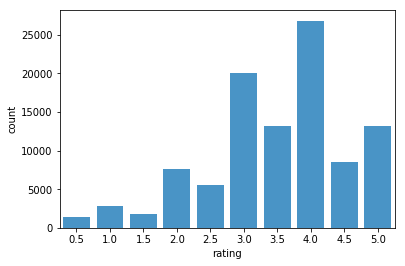

In [11]:
# count of different rating scores
sns.barplot(x="rating", y="count", color='#3498db', data=ratings.groupBy('rating').count().toPandas())
plt.savefig('fig_001.png', dpi=600)

In [12]:
# average rating of movies
ratings.groupBy('MovieID').agg(mean('rating')).toPandas().head()

,MovieID,avg(rating)
0,1580,3.487879
1,2366,3.640000
2,3175,3.580000
3,1088,3.369048
4,32460,4.250000


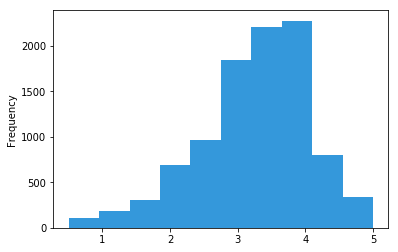

In [13]:
# average rating of movies
ratings.groupBy('MovieID').agg(mean('rating')).toPandas()['avg(rating)'].plot(kind='hist', color='#3498db')
plt.savefig('fig_002.png', dpi=600)

In [14]:
# average rating from users
ratings.groupBy('userID').agg(mean('rating')).toPandas().head()

,userID,avg(rating)
0,148,3.739583
1,463,3.787879
2,471,3.875000
3,496,3.413793
4,243,4.138889


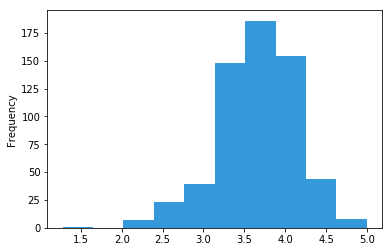

In [15]:
# average rating from users
ratings.groupBy('userID').agg(mean('rating')).toPandas()['avg(rating)'].plot(kind='hist', color='#3498db')
plt.savefig('fig_003.png', dpi=600)

**Movies**

The file `movies.csv` contains the `movieId`, `title` and `genres` for each movie. As you can see, the `genres` field is a bit tricky to use, as the genres are in the form of one string delimited by the `|` character: `Adventure|Animation|Children|Comedy|Fantasy`.

In [16]:
# load raw data from CSV
raw_movies = spark.read.csv(PATH_TO_DATA + "/movies.csv", header=True, inferSchema=True)

print("Number of rows %i" % raw_movies.count())
print("Raw movie data:")
raw_movies.show(5, truncate=False)

Number of rows 9742
Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



Create a `DataFrame` user-defined function (UDF) to extract this delimited string into a list of genres.

In [17]:
# define a UDF to convert the raw genres string to an array of genres and lowercase
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))
# test it out
raw_movies.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



Ok, that looks better!

You may also notice that the movie titles contain the year of release. It would be useful to have that as a field in your search index for filtering results (say you want to filter our recommendations to include only more recent movies).

Create a UDF to extract the release year from the title using a Python regular expression.

In [18]:
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    
# test out our function
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

Ok the function works! Now create a new `DataFrame` with the cleaned-up titles, release dates and genres of the movies.

In [19]:
movies = raw_movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))

print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



Next, join the `links.csv` data to `movies` so that there is an id for _The Movie Database_ corresponding to each movie. You can use this id to retrieve movie poster images when displaying your recommendations later.

In [20]:
link_data = spark.read.csv(PATH_TO_DATA + "/links.csv", header=True, inferSchema=True)

# join movies with links to get TMDB id
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, link_data.tmdbId)

num_movies = movie_data.count()

print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+------------------------------------------------

> **_Display movie posters using TMDb API_**

> Run the below cell to test your access to TMDb API. You should see the _Toy Story_ movie poster displayed inline.

> To install the Python package run `pip install tmdbsimple`

> Replace [YOUR KEY] below with your TMDb API key. 

Successfully imported tmdbsimple!


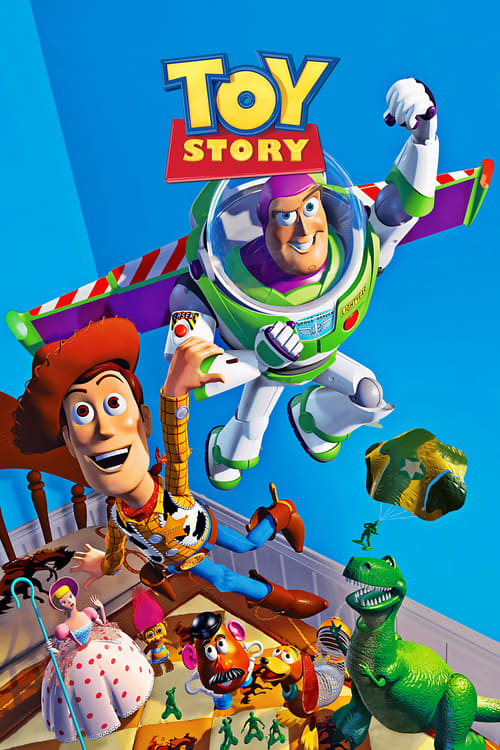

In [21]:
try:
    import tmdbsimple as tmdb
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY = 'aecc7ca9f4c9a64d8068b47703b18ca6'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except Exception:
    print("Cannot import tmdbsimple, no movie posters will be displayed!")

## Step 2: Write data in Elasticsearch

run `./bin/elasticsearch` first to start elasticsearch

In [22]:
# test your ES instance is running
es = Elasticsearch()
es.info(pretty=True)

{'name': '5zpH6GX',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'cWqeDZ72RSqLptLtsSeHNQ',
 'version': {'number': '5.3.0',
  'build_hash': '3adb13b',
  'build_date': '2017-03-23T03:31:50.652Z',
  'build_snapshot': False,
  'lucene_version': '6.4.1'},
 'tagline': 'You Know, for Search'}

### Create an Elasticsearch index with mappings for users, movies and rating events

In Elasticsearch, an "index" is roughly similar to a "database", while a "document type" is roughly similar to a "table" in that database. The schema for a document type is called an index mapping.

While Elasticsearch supports dynamic mapping, it's advisable to specify the mapping explicitly when creating an index if you know what your data looks like.

For the purposes of your recommendation engine, this is also necessary so that you can specify a custom analyzer for the field that will hold the recommendation "model" (that is, the factor vectors). This will ensure the vector-scoring plugin will work correctly.


__References:__
* [Create index request](https://www.elastic.co/guide/en/elasticsearch/reference/current/indices-create-index.html)
* [Delimited payload filter](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/analysis-delimited-payload-tokenfilter.html)
* [Term vectors](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/docs-termvectors.html#_term_information)
* [Mapping](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/mapping.html)

> **_Optional_**

> If you are re-running the notebook and have previously created the `movie_rec` index in Elasticsearch, you should first delete it by un-commenting and running the next cell, before running the index creation cell that follows.

In [23]:
es.indices.delete(index="movie_rec")

{'acknowledged': True}

In [24]:
create_index = {
    "settings": {
        "analysis": {
            "analyzer": {
                # this configures the custom analyzer we need to parse vectors such that the scoring
                # plugin will work correctly
                "payload_analyzer": {
                    "type": "custom",
                    "tokenizer":"whitespace",
                    "filter":"delimited_payload_filter"
                }
            }
        }
    },
    "mappings": {
        "ratings": {
          # this mapping definition sets up the fields for the rating events
          "properties": {
                "timestamp": {
                    "type": "date"
                },
                "userId": {
                    "type": "integer"
                },
                "movieId": {
                    "type": "integer"
                },
                "rating": {
                    "type": "double"
                }
            }  
        },
        "users": {
            # this mapping definition sets up the metadata fields for the users
            "properties": {
                "userId": {
                    "type": "integer"
                },
                "@model": {
                    # this mapping definition sets up the fields for user factor vectors of our model
                    "properties": {
                        "factor": {
                            "type": "text",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "keyword"
                        },
                        "timestamp": {
                            "type": "date"
                        }
                    }
                }
            }
        },
        "movies": {
            # this mapping definition sets up the metadata fields for the movies
            "properties": {
                "movieId": {
                    "type": "integer"
                },
                "tmdbId": {
                    "type": "keyword"
                },
                "genres": {
                    "type": "keyword"
                },
                "release_date": {
                    "type": "date",
                    "format": "year"
                },
                "@model": {
                    # this mapping definition sets up the fields for movie factor vectors of our model
                    "properties": {
                        "factor": {
                            "type": "text",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "keyword"
                        },
                        "timestamp": {
                            "type": "date"
                        }
                    }
                }
            }
        }
    }
}

# create index with the settings and mappings above
es.indices.create(index="movie_rec", body=create_index)

{'acknowledged': True, 'shards_acknowledged': True}

### Load Ratings and Movies DataFrames into Elasticsearch

First you will write the ratings data to Elasticsearch. Notice that you can simply use the Spark Elasticsearch connector to write a `DataFrame` with the native Spark datasource API by specifying `format("es")`

In [25]:
# write ratings data
ratings.write.format("es").save("movie_rec/ratings")

# write movie data, specifying the DataFrame column to use as the id mapping
# each document has an unique id 
# if it is not specified, an id will be assigned by Elasticsearch
movie_data.write.format("es").option("es.mapping.id", "movieId").save("movie_rec/movies")

# check load went ok
print("Movie DF count: %d" % movie_data.count())
print("ES index count: %d" % es.count(index="movie_rec", doc_type="movies")['count'])

# check write went ok
print("Rating DF count: %d" % ratings.count())
print("ES index count:  %d" % es.count(index="movie_rec", doc_type="ratings")['count'])

Movie DF count: 9742
ES index count: 9742
Rating DF count: 100836
ES index count:  100836


In [26]:
# test things out by retrieving 3 rating documents from Elasticsearch
es.search(index="movie_rec", doc_type="ratings", q="*", size=3)

{'took': 9,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'failed': 0},
 'hits': {'total': 100836,
  'max_score': 1.0,
  'hits': [{'_index': 'movie_rec',
    '_type': 'ratings',
    '_id': 'AWgib7u5IdQQIkHn6v89',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 163,
     'rating': 5.0,
     'timestamp': 964983650000}},
   {'_index': 'movie_rec',
    '_type': 'ratings',
    '_id': 'AWgib7u5IdQQIkHn6v9B',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 235,
     'rating': 4.0,
     'timestamp': 964980908000}},
   {'_index': 'movie_rec',
    '_type': 'ratings',
    '_id': 'AWgib7u5IdQQIkHn6v9E',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 316,
     'rating': 3.0,
     'timestamp': 964982310000}}]}}

In [27]:
# we can use es to query documents 
# e.g. count ratings with timestamp between 2016-01-01 and 2016-02-01
es.count(index="movie_rec", doc_type="ratings", q="timestamp:[2016-01-01 TO 2016-02-01]")

{'count': 344, '_shards': {'total': 5, 'successful': 5, 'failed': 0}}

In [28]:
# test things out by searching for movies containing "matrix" in the title
es.search(index="movie_rec", doc_type="movies", q="title:matrix", size=3)

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'failed': 0},
 'hits': {'total': 3,
  'max_score': 6.955335,
  'hits': [{'_index': 'movie_rec',
    '_type': 'movies',
    '_id': '2571',
    '_score': 6.955335,
    '_source': {'movieId': 2571,
     'title': 'Matrix, The',
     'release_date': '1999',
     'genres': ['action', 'sci-fi', 'thriller'],
     'tmdbId': 603}},
   {'_index': 'movie_rec',
    '_type': 'movies',
    '_id': '6365',
    '_score': 5.816114,
    '_source': {'movieId': 6365,
     'title': 'Matrix Reloaded, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 604}},
   {'_index': 'movie_rec',
    '_type': 'movies',
    '_id': '6934',
    '_score': 5.816114,
    '_source': {'movieId': 6934,
     'title': 'Matrix Revolutions, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 605}}]}}

## Step 3: Train a recommmender model


__Further reading:__

* [Spark MLlib Collaborative Filtering](http://spark.apache.org/docs/latest/ml-collaborative-filtering.html)
* [Alternating Least Squares and collaborative filtering](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/)
* [Quora question on Alternating Least Squares](https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems-And-why-does-this-algorithm-work-intuition-behind-this)


In [29]:
ratings_from_es = spark.read.format("es").load("movie_rec/ratings")

# train test split
train, test = ratings_from_es.randomSplit([0.7, 0.3], seed=7856)
train.show(5)

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|      1|   2.0|2006-09-11 04:56:25|   132|
|      1|   2.5|2004-05-14 01:02:09|    82|
|      1|   3.0|1996-12-16 06:22:17|   544|
|      1|   3.0|1997-02-24 06:15:19|    32|
|      1|   3.5|2011-09-17 02:02:37|   213|
+-------+------+-------------------+------+
only showing top 5 rows



In [30]:
als_obj = ALS()

# use grid search to tune parameters
params_grid  = ParamGridBuilder()\
    .baseOn({als_obj.coldStartStrategy: "drop"})\
    .baseOn({als_obj.userCol: "userId"})\
    .baseOn({als_obj.itemCol: "movieId"})\
    .baseOn({als_obj.ratingCol: "rating"})\
    .baseOn({als_obj.maxIter: 20})\
    .addGrid(als_obj.regParam, [1e-3, 0.05, 0.1, 0.5, 1, 10, 100])\
    .addGrid(als_obj.rank, [6, 8, 10, 12, 14])\
    .build()

# define evaluator with mse eror
mse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# 3-fold cross validation
cv_setting = CrossValidator(estimator=als_obj, estimatorParamMaps=params_grid, evaluator=mse_evaluator, numFolds=3)
cv_model = cv_setting.fit(train)


In [31]:
model = cv_model.bestModel
model.userFactors.show(5)
model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.31396616, -0....|
| 20|[-0.88751113, -0....|
| 30|[-0.22664993, 0.2...|
| 40|[-0.5835698, -0.2...|
| 50|[-0.2547228, -0.5...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.13357298, -0.3...|
| 20|[-0.09831667, -0....|
| 30|[-0.31642506, -0....|
| 40|[-1.0019568, -0.4...|
| 50|[-0.44067842, -0....|
+---+--------------------+
only showing top 5 rows



In [32]:
print("parameters of the best model: \n{}".format(cv_setting.getEstimatorParamMaps()[np.argmin(cv_model.avgMetrics)]))
print("-----")
print("cross validation RMSE of the best model: {}".format(min(cv_model.avgMetrics)))

parameters of the best model: 
{Param(parent='ALS_43d68cba25f6cd191152', name='coldStartStrategy', doc="strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: 'nan', 'drop'."): 'drop', Param(parent='ALS_43d68cba25f6cd191152', name='userCol', doc='column name for user ids. Ids must be within the integer value range.'): 'userId', Param(parent='ALS_43d68cba25f6cd191152', name='itemCol', doc='column name for item ids. Ids must be within the integer value range.'): 'movieId', Param(parent='ALS_43d68cba25f6cd191152', name='ratingCol', doc='column name for ratings'): 'rating', Param(parent='ALS_43d68cba25f6cd191152', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='ALS_43d68cba25f6cd191152', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='ALS_43d68cba25f6cd191152', name

In [33]:
a = iter(list(cv_model.avgMetrics[:]))
res = []
for x in [1e-3, 0.05, 0.1, 0.5, 1, 10, 100]:
    for y in [6, 8, 10, 12, 14]:
        res.append((x, y, next(a)))
for item in res:
    print('|' + '|'.join(list(map(str, item))) + '|')

|0.001|6|1.263518217332885|
|0.001|8|1.2014371426375456|
|0.001|10|1.422620538562651|
|0.001|12|1.3604324601262419|
|0.001|14|1.4574997197413984|
|0.05|6|0.8088049496829319|
|0.05|8|0.8290710658768647|
|0.05|10|0.7869832819126761|
|0.05|12|0.8225115140688619|
|0.05|14|0.8130705203773324|
|0.1|6|0.8001947254948074|
|0.1|8|0.8210528283991319|
|0.1|10|0.8056105653205774|
|0.1|12|0.8268666454519422|
|0.1|14|0.7685381377400587|
|0.5|6|0.9709804345615689|
|0.5|8|0.9785540200363918|
|0.5|10|0.9751182941500205|
|0.5|12|0.9737259458282794|
|0.5|14|0.9693330512533402|
|1|6|1.3036434176524154|
|1|8|1.3050059254923407|
|1|10|1.29715655821004|
|1|12|1.3058088556346292|
|1|14|1.3071238166633987|
|10|6|3.6652294413380373|
|10|8|3.663117526357053|
|10|10|3.662855323997312|
|10|12|3.6643443889986536|
|10|14|3.664414114179853|
|100|6|3.663316167320345|
|100|8|3.665100695738553|
|100|10|3.66533856079971|
|100|12|3.6636380479971447|
|100|14|3.665309355304111|


In [34]:
mse_evaluator.evaluate((model.transform(test)))

0.8017253194100687

## Step 4: Export ALS user and item factor vectors to Elasticsearch

The next step is to export the model factors (shown in the `DataFrames` above) to Elasticsearch.

In order to store the model in the correct format for the index mappings set up earlier, you will need to create some utility functions. These functions will allow you to convert the raw vectors (which are equivalent to a Python list in the factor `DataFrames` above) to the correct _delimited string format_. This ensures Elasticsearch will parse the vector field in the model correctly using the delimited token filter custom analyzer you configured earlier.

You will also create a function to convert a vector and related metadata (such as the Spark model id and a timestamp) into a `DataFrame` field that matches the `model` field in the Elasticsearch index mapping.

### Utility functions for converting factor vectors

In [35]:
def convert_vector(x):
    '''Convert a list or numpy array to delimited token filter format'''
    return " ".join(["%s|%s" % (i, v) for i, v in enumerate(x)])

def reverse_convert(s):
    '''Convert a delimited token filter format string back to list format'''
    return  [float(f.split("|")[1]) for f in s.split(" ")]

def vector_to_struct(x, version, ts):
    '''Convert a vector to a SparkSQL Struct with string-format vector and version fields'''
    return (convert_vector(x), version, ts)

vector_struct = udf(vector_to_struct, \
                    StructType([StructField("factor", StringType(), True), \
                                StructField("version", StringType(), True),\
                                StructField("timestamp", LongType(), True)]))

In [36]:
convert_vector([1,2,3])

'0|1 1|2 2|3'

In [37]:
# test out the vector conversion function
test_vec = model.userFactors.select("features").first().features
print(test_vec)
print()
print(convert_vector(test_vec))

[-0.31396615505218506, -0.48426249623298645, -0.32465702295303345, 0.7441086769104004, 0.2473457306623459, -0.09887886792421341, -1.0797762870788574, -0.2240457534790039, -0.2531317174434662, -0.04525450989603996, -0.7288685441017151, -0.46853530406951904, 0.07799006998538971, 1.464194893836975]

0|-0.31396615505218506 1|-0.48426249623298645 2|-0.32465702295303345 3|0.7441086769104004 4|0.2473457306623459 5|-0.09887886792421341 6|-1.0797762870788574 7|-0.2240457534790039 8|-0.2531317174434662 9|-0.04525450989603996 10|-0.7288685441017151 11|-0.46853530406951904 12|0.07799006998538971 13|1.464194893836975


### Convert factor vectors to [factor, version, timestamp] form and write to Elasticsearch

In [38]:
ver = model.uid
ts = unix_timestamp(current_timestamp())

movie_vectors = model.itemFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
movie_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)

user_vectors = model.userFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
user_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)

+---+--------------------+--------------------+----------+
| id|              factor|             version| timestamp|
+---+--------------------+--------------------+----------+
| 10|0|0.1335729807615...|ALS_43d68cba25f6c...|1546766869|
| 20|0|-0.098316669464...|ALS_43d68cba25f6c...|1546766869|
| 30|0|-0.316425055265...|ALS_43d68cba25f6c...|1546766869|
| 40|0|-1.001956820487...|ALS_43d68cba25f6c...|1546766869|
| 50|0|-0.440678417682...|ALS_43d68cba25f6c...|1546766869|
+---+--------------------+--------------------+----------+
only showing top 5 rows

+---+--------------------+--------------------+----------+
| id|              factor|             version| timestamp|
+---+--------------------+--------------------+----------+
| 10|0|-0.313966155052...|ALS_43d68cba25f6c...|1546766869|
| 20|0|-0.887511134147...|ALS_43d68cba25f6c...|1546766869|
| 30|0|-0.226649925112...|ALS_43d68cba25f6c...|1546766869|
| 40|0|-0.583569824695...|ALS_43d68cba25f6c...|1546766869|
| 50|0|-0.254722803831...|ALS_4

In [39]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "update" write mode for ES, since you want to update new fields only
# - "append" write mode for Spark
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("movie_rec/movies", mode="append")

In [42]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "index" write mode for ES, since you have not written to the user index previously
# - "append" write mode for Spark
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "index") \
    .save("movie_rec/users", mode="append")

### Check the data  was written correctly

You can search for a movie to see if the model factor vector was written correctly. You should see a `'@model': {'factor': '0|...` field in the returned movie document.

In [43]:
# search for a particular sci-fi movie
es.search(index="movie_rec", doc_type="movies", q="star wars phantom menace", size=1)['hits']['hits'][0]

{'_index': 'movie_rec',
 '_type': 'movies',
 '_id': '135216',
 '_score': 11.353123,
 '_source': {'movieId': 135216,
  'title': 'The Star Wars Holiday Special',
  'release_date': '1978',
  'genres': ['adventure', 'children', 'comedy', 'sci-fi'],
  'tmdbId': 74849}}

## Step 5: Recommend using Elasticsearch!

Now that you have loaded your recommendation model into Elasticsearch, you will generate some recommendations.
First, you will need to create a few utility functions for:

* Fetching movie posters from TMdb API (optional)
* Constructing the Elasticsearch [function score query](https://www.elastic.co/guide/en/elasticsearch/reference/5.3/query-dsl-function-score-query.html) to generate recommendations from your factor model
* Given a movie, use this query to find the movies most similar to it
* Given a user, use this query to find the movies with the highest predicted rating, to recommend to the user
* Display the results as an HTML table in Jupyter

In [45]:
from IPython.display import Image, HTML, display

def get_poster_url(id):
    """Fetch movie poster image URL from TMDb API given a tmdbId"""
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        try:
            movie = tmdb.Movies(id).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"
    
    
def fn_query(query_vec, q="*", cosine=False):
    """
    Construct an Elasticsearch function score query.
    
    The query takes as parameters:
        - the field in the candidate document that contains the factor vector
        - the query vector
        - a flag indicating whether to use dot product or cosine similarity (normalized dot product) for scores
        
    The query vector passed in will be the user factor vector (if generating recommended movies for a user)
    or movie factor vector (if generating similar movies for a given movie)
    """
    return {
    "query": {
        "function_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script_score": {
                "script": {
                        "inline": "payload_vector_score",
                        "lang": "native",
                        "params": {
                            "field": "@model.factor",
                            "vector": query_vec,
                            "cosine" : cosine
                        }
                    }
            },
            "boost_mode": "replace"
        }
    }
}


def get_similar(the_id, q="*", num=10, index="movie_rec", dt="movies"):
    """
    Given a movie id, execute the recommendation function score query to find similar movies, ranked by cosine similarity
    """
    response = es.get(index=index, doc_type=dt, id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=True)
        results = es.search(index, dt, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]
    
    
def get_user_recs(the_id, q="*", num=10, index="movie_rec"):
    """
    Given a user id, execute the recommendation function score query to find top movies, ranked by predicted rating
    """
    response = es.get(index=index, doc_type="users", id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=False)
        results = es.search(index, "movies", body=q)
        hits = results['hits']['hits']
        return src, hits[:num]

def get_movies_for_user(the_id, num=10, index="movie_rec"):
    """
    Given a user id, get the movies rated by that user, from highest- to lowest-rated.
    """
    response = es.search(index=index, doc_type="ratings", q="userId:%s" % the_id, size=num, sort=["rating:desc"])
    hits = response['hits']['hits']
    ids = [h['_source']['movieId'] for h in hits]
    movies = es.mget(body={"ids": ids}, index=index, doc_type="movies", _source_include=['tmdbId', 'title'])
    movies_hits = movies['docs']
    tmdbids = [h['_source'] for h in movies_hits]
    return tmdbids

            
def display_user_recs(the_id, q="*", num=10, num_last=10, index="movie_rec"):
    user, recs = get_user_recs(the_id, q, num, index)
    user_movies = get_movies_for_user(the_id, num_last, index)
    # check that posters can be displayed
    first_movie = user_movies[0]
    first_im_url = get_poster_url(first_movie['tmdbId'])
    if first_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if first_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    # display the movies that this user has rated highly
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        movie_im_url = get_poster_url(movie['tmdbId'])
        movie_title = movie['title']
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    # now display the recommended movies for the user
    display(HTML("<br>"))
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))

    
def display_similar(the_id, q="*", num=10, index="movie_rec", dt="movies"):
    """
    Display query movie, together with similar movies and similarity scores, in a table
    """
    movie, recs = get_similar(the_id, q, num, index, dt)
    q_im_url = get_poster_url(movie['tmdbId'])
    if q_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if q_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(HTML("<h4>%s</h4>" % movie['title']))
    if q_im_url != "NA":
        display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>People who liked this movie also liked these:</h2>"))
    sim_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

Now, you're ready to generate some recommendations.

### 5(a) Find similar movies for a given movie

To start, you can find movies that are _similar_ to a given movie. This similarity score is computed from the model factor vectors for each movie. Recall that the ALS model you trained earlier is a collaborative filtering model, so the similarity between movie vectors will be based on the _rating co-occurrence_ of the movies. In other words, two movies that tend to be rated highly by a user will tend to be more similar. It is common to use the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) of the movie factor vectors as a measure of the similarity between two movies.

Using this similarity you can show recommendations along the lines of _people who liked this movie also liked these_.

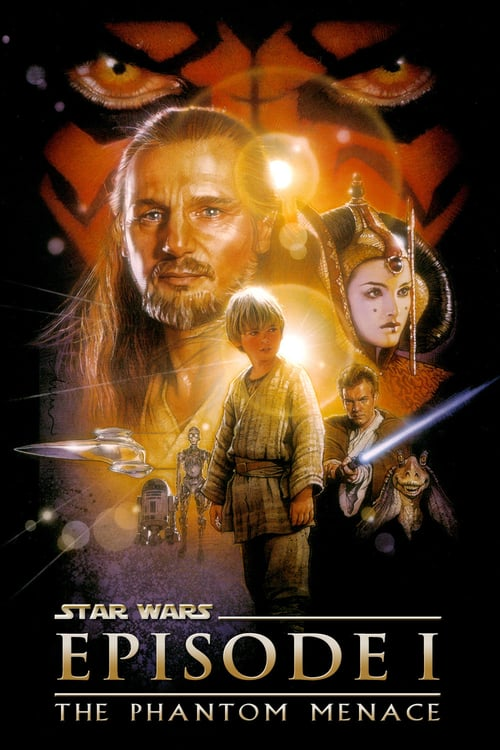

In [46]:
display_similar(2628, num=5)

So we see that people who like Star Wars tend like other sci-fi movies (including other Star Wars films), as well as some action and drama.

> _Note_ since we are using a very small dataset, results may not be as good as those for the same model trained on a larger dataset.

Now you will see the power and flexibility that comes from using a search engine to generate recommendations. Elasticsearch allows you to tweak the results returned by the recommendation query using any standard search query or filter - from free text search through to filters based on time and geo-location (or any other piece of metadata you can think of).

For example, perhaps you want to remove any movies with "matrix" in the title from the recommendations. You can do this by simply passing a valid Elasticsearch query string to the recommendation function.

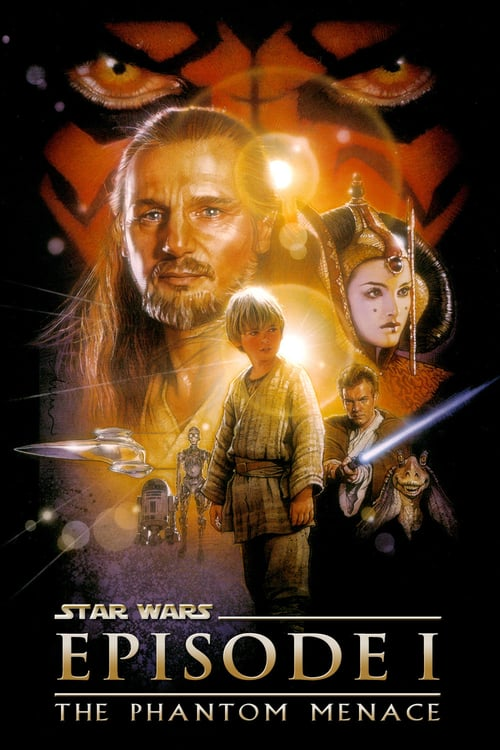

In [47]:
display_similar(2628, num=5, q="title:(NOT matrix)")

Or you may want to ensure that only valid children's movies are shown to young viewers.

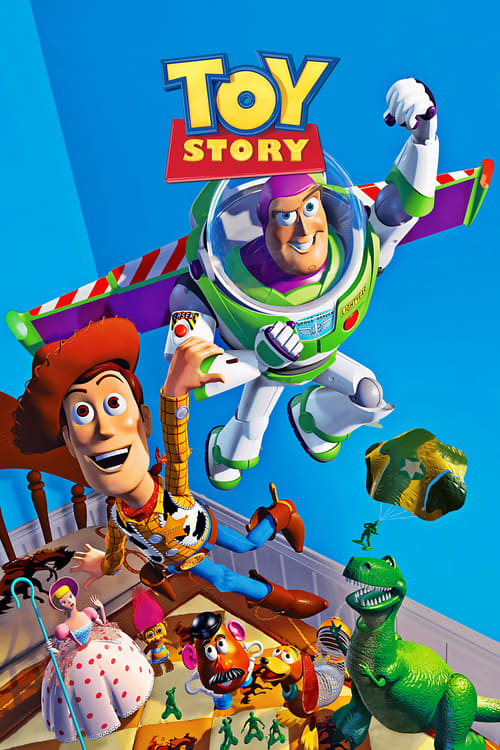

In [48]:
display_similar(1, num=5, q="genres:children")

Feel free to check out the documentation for the Elasticsearch [query string query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-query-string-query.html) and play around with the various queries you can construct by passing in a query string as `q` in the recommendation function above!

### 5(b) Find movies to recommend to a user

Now, you're ready to generate some movie recommendations, personalized for a specific user.

Given a user, you can recommend movies to that user based on the predicted ratings from your model. In a similar manner to the similar movie recommendations, this predicted rating score is computed from the model factor vector for the user and the factor vectors for each movie. Recall that the collaborative filtering model means that, at a high level, we will recommend movies _liked by other users who liked the same movies as the given user_.

In [49]:
display_user_recs(12, num=5, num_last=5)

Again, note that since we are using a very small dataset, the results may not be too good. However, we can see that this user seems to like some sci-fi, some horror and some comedy films. The recommended movies fall broadly into these categories and seem to be somewhat reasonable.

Next, you can again apply the power of Elasticsearch's filtering capabilities to your recommendation engine. Let's say you only want to recommend more recent movies (say, from the past 5 years). This can be done by adding a date math query to the recommendation function score query.

In [50]:
display_user_recs(12, num=5, num_last=5, q="release_date:[2012 TO *]")

You can see that the recommendation include only recent movies, and this time they seem to be heavily tilted to sci-fi and fantasy genres.

As you did with the similar movies recommendations, feel free to play around with the various queries you could pass into the user recommendation query.